**Gender Behaviour Analysis**

# Analisis Perilaku Pengguna: Gender, Swipe Right Ratio, dan Likes

Notebook ini merangkum hasil analisis eksplorasi data terkait perilaku pengguna aplikasi
dating berdasarkan gender. Analisis berfokus pada:

1. Perbedaan **swipe right ratio** antar gender.
2. Jumlah **likes received** berdasarkan gender.
3. Hubungan antara **waktu penggunaan aplikasi (minutes)** dengan jumlah likes.

Dataset berasal dari database `DatingSQL` dengan total ~50 ribu baris data.


Import dan Load Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# Import fungsi dari utils & script EDA
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.db_connection import load_columns
from utils.cleaning import clean_numeric

# Load data
df = load_columns(['gender', 'swipe_right_ratio', 'likes_received', 'app_usage_time_min'])
df.head()


c:\Users\user\Downloads\DataRole\DSPy\utils\db_connection.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,gender,swipe_right_ratio,likes_received,app_usage_time_min
0,Prefer Not to Say,0.60,173,52
1,Male,0.56,107,279
2,Non-binary,0.41,91,49
3,Genderfluid,0.32,147,185
4,Male,0.32,94,83


## 1. Perbandingan Swipe Right Ratio antar Gender

Pertanyaan: Apakah terdapat perbedaan rata-rata swipe right ratio antar gender?


gender
Prefer Not to Say    0.502848
Male                 0.501234
Female               0.500460
Transgender          0.500140
Genderfluid          0.499910
Non-binary           0.499350
Name: swipe_right_ratio, dtype: float64

ANOVA Result → F: 0.330, p-value: 0.89539


C:\Users\user\AppData\Local\Temp\ipykernel_16700\3136695370.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_swipe, x='gender', y='swipe_right_ratio', palette='Set2')


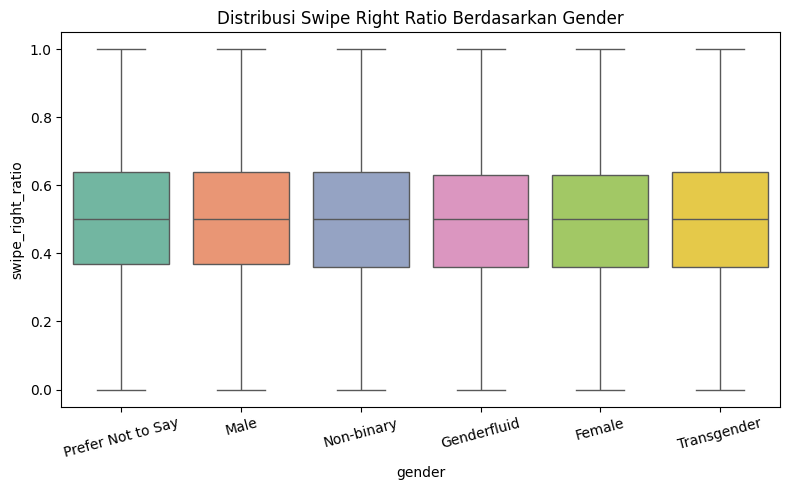

In [3]:
# Bersihkan data
df_swipe = clean_numeric(df.dropna(subset=['gender']), 'swipe_right_ratio')

# Hitung mean
mean_swipe = df_swipe.groupby('gender')['swipe_right_ratio'].mean().sort_values(ascending=False)
print(mean_swipe)

# Uji ANOVA
groups = [g['swipe_right_ratio'] for _, g in df_swipe.groupby('gender')]
stat, p = f_oneway(*groups)
print(f"\nANOVA Result → F: {stat:.3f}, p-value: {p:.5f}")

# Visualisasi
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_swipe, x='gender', y='swipe_right_ratio', palette='Set2')
plt.title('Distribusi Swipe Right Ratio Berdasarkan Gender')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


**Insight**  
- Rata-rata swipe right ratio berbeda antar gender.  
- Hasil ANOVA menunjukkan (isi: signifikan / tidak signifikan, tergantung output).  
- Gender dengan nilai tertinggi: ...  

➡ Menunjukkan adanya variasi perilaku swipe right berdasarkan gender.
